In [1]:
import os
import gc
from time import time

import natsort
from itertools import count
# import torch
# from pydub import AudioSegment, silence

# Math
from scipy.io import wavfile
import librosa
import numpy as np
from scipy import signal
from scipy.signal import find_peaks

# # Visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

import librosa.display
from IPython.display import Audio
from IPython.display import HTML

import itertools
import noisereduce as nr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
import sklearn

# keras module
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, Embedding, LSTM, Bidirectional, SimpleRNN, GRU

from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# Hyperparameters
# sample_rate = 16000
freq_lim = 2048

In [2]:
import os

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import mglearn
from os.path import join

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer,accuracy_score,f1_score,roc_auc_score,roc_curve,confusion_matrix,auc
from sklearn.metrics import RocCurveDisplay,ConfusionMatrixDisplay
# import umap
from sklearn.manifold import TSNE

In [3]:
tf.__version__

'2.1.0'

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2243978406703953505,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1806852802119244479
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12201022640890952342
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3923527720988639927
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8433502640300873451
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 56683598549657858
 physical_device_desc: "device: XLA_GPU device",
 na

In [6]:
for i in range(2):
    gc.collect()
gc.collect()

0

# Funcition definition 

In [7]:
def make_train_dataset_keras(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio):
    
    data_list = []
    label_list = []
    
    pitch_var = [-3.5, -2, 2, 3.5]
    augmented_number = len(pitch_var)

    for index, file in enumerate(ordered_file_list):
        
        if file[-3:] == 'wav':

            # data load 
            sample_rate = librosa.get_samplerate(file_path + '/' + file)
            # calculated values
            frame_length = int(frame_sec * sample_rate)
            frame_step = int(step_sec * sample_rate)
            data, data_sr = librosa.load(file_path + '/' + file, sr = sample_rate)
            
            for pitch in pitch_var:
                
                ps_data = librosa.effects.pitch_shift(data, sr = sample_rate, n_steps = pitch)

                # mel spectrogram extraction
                melS = librosa.feature.melspectrogram(y = ps_data, sr=sample_rate, n_mels=n_mels,
                                                      hop_length=frame_step, win_length=frame_length)
                melS = librosa.power_to_db(melS, ref=np.max)

                data_list.append(melS.T)
                
            # normal and wheeze split
            normal_event = []
            wheeze_event = []
                
            label = pd.read_csv(file_path + '/' + file[:-3] + 'txt', sep='\t', header=None)
            
            sec_to_index_start = label[0]*16000
            sec_to_index_end = label[1]*16000
            sec_to_index_start = sec_to_index_start.to_numpy().round()
            sec_to_index_end = sec_to_index_end.to_numpy().round()

            for i, val in enumerate(label[2].to_numpy()):
                if val == 'normal':
                    normal_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)),
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

                elif val == 'wheeze':
                    wheeze_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)),
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

            normal_event = np.array(normal_event)
            wheeze_event = np.array(wheeze_event)
            
            y = np.zeros(len(data_list[-1]))
 
            # label ratio decision
            for j in normal_event:
                start = j[0]
                end = j[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 1

            for k in wheeze_event:
                start = k[0]
                end = k[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 2
                
            for number in range(augmented_number):
                label_list.append(y)
                
    X = np.concatenate(data_list, axis = 0)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.concatenate(label_list, axis = 0)
    y = utils.to_categorical(y)
    
    return X, y


def make_validation_dataset_keras(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio):


    data_list = []
    label_list = []

    for index, file in enumerate(ordered_file_list):
        if file[-3:] == 'wav':

            # data load 
            sample_rate = librosa.get_samplerate(file_path + '/' + file)
            data, data_sr = librosa.load(file_path + '/' + file, sr = sample_rate)
#             data = nr.reduce_noise(data, sr = sample_rate)

            # framing condition
            frame_length = int(frame_sec * sample_rate)
            frame_step = int(step_sec * sample_rate)

            # mel spectrogram extraction
            melS = librosa.feature.melspectrogram(y = data, sr=sample_rate, n_mels=n_mels,
                                                  hop_length=frame_step, win_length=frame_length)
            melS = librosa.power_to_db(melS, ref=np.max)
#             melS = librosa.power_to_db(melS, ref=np.median)

            data_list.append(melS.T)

    # X must be extracted first

    for index, file in enumerate(ordered_file_list):

        if file[-3:] == 'txt':

            # normal and wheeze split
            normal_event = []
            wheeze_event = []

            label = pd.read_csv(file_path + '/' + file, sep='\t', header=None)

            sec_to_index_start = label[0]*16000
            sec_to_index_end = label[1]*16000
            sec_to_index_start = sec_to_index_start.to_numpy().round()
            sec_to_index_end = sec_to_index_end.to_numpy().round()

            for i, val in enumerate(label[2].to_numpy()):
                if val == 1:
                    normal_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

                elif val == 2:
                    wheeze_event.append([int(sec_to_index_start[i]//(step_sec*sample_rate)), 
                                         int(sec_to_index_end[i]//(step_sec*sample_rate))])

            normal_event = np.array(normal_event)
            wheeze_event = np.array(wheeze_event)

            y = np.zeros(len(data_list[int(index/2)]))

            # label ratio decision

            for j in normal_event:
                start = j[0]
                end = j[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 1
#                 y[end:end+delta] = 1


            for k in wheeze_event:
                start = k[0]
                end = k[1]
                delta = int((end-start)*label_ratio)
                y[end-delta:end] = 2
#                 y[end:end+delta] = 2


            label_list.append(y)
    
    X = np.concatenate(data_list, axis = 0)
    X = X.reshape(X.shape[0], X.shape[1])
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.concatenate(label_list, axis = 0)
    y = utils.to_categorical(y)
    
    return X, y


def make_test_dataset_keras(test_signal, test_label, n_mels, frame_sec, step_sec):
    
    # test signal must be noise filtered

    # framing condition
    frame_length = int(frame_sec * sample_rate)
    frame_step = int(step_sec * sample_rate)
    
    # noise reduce
    test_signal = nr.reduce_noise(test_signal, sr = sample_rate)

    # mel spectrogram extraction
    melS = librosa.feature.melspectrogram(y = test_signal, sr=sample_rate, 
                                          n_mels=n_mels, hop_length=frame_step, win_length=frame_length)
    melS = librosa.power_to_db(melS, ref=np.max)
#     melS = librosa.power_to_db(melS, ref=np.median)

    X_test = melS.T
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
    
    sec_to_index = test_label[0]*16000
    event_index = sec_to_index//(step_sec*sample_rate)

    y_test = np.zeros(len(X_test))

    for i in event_index:
        y_test[int(i)] = 2
        
    return X_test, y_test


def wheeze_per_resp_acc(y_pred, y_test):
    
    peaks, _ = find_peaks(y_pred)

    after_peaks = peaks[1:]
    before_peaks = peaks[:-1]

    term = after_peaks - before_peaks

    start = 0
    pred_resp_count = 0
    pred_normal_count = 0
    pred_wheeze_count = 0

    for index, val in enumerate(term):
        if val >= 100:
            pred_resp_count += 1
            thres = y_pred[peaks[start:index+1]].mean()
            if thres > 1.0:
                pred_wheeze_count += 1
            elif thres == 1.0 : 
                pred_normal_count += 1
            start = index+1
    
    print('prediction')
    print(pred_wheeze_count, '/', pred_resp_count)
    
    peaks, _ = find_peaks(y_test)

    after_peaks = peaks[1:]
    before_peaks = peaks[:-1]

    term = after_peaks - before_peaks

    start = 0
    test_resp_count = 0
    test_normal_count = 0
    test_wheeze_count = 0

    for index, val in enumerate(term):
        if val >= 100:
            test_resp_count += 1
            thres = y_test[peaks[start:index+1]].mean()
            if thres > 1.0:
                test_wheeze_count += 1
            elif thres == 1.0 : 
                test_normal_count += 1
            start = index+1
             
    print('test')
    print(test_wheeze_count, '/', test_resp_count)
    
    return pred_wheeze_count, pred_resp_count

In [8]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='roc_auc',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
#         cv=cv, 
        n_jobs=1, 
#         scoring=scoring_fit,
#         verbose=2
    )
    
    gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = gs.predict_proba(X_test_data)
    else:
        pred = gs.predict(X_test_data)
    
    return gs, pred

## fixed parameter results

In [9]:
file_path= 'data/train_with_ICBHI'
file_list = os.listdir(file_path)
ordered_file_list = natsort.natsorted(file_list)
ordered_file_list

['103_2b2_Ar_mc_LittC2SE.txt',
 '103_2b2_Ar_mc_LittC2SE.wav',
 '106_2b1_Pr_mc_LittC2SE.txt',
 '106_2b1_Pr_mc_LittC2SE.wav',
 '121_1b1_Tc_sc_Meditron.txt',
 '121_1b1_Tc_sc_Meditron.wav',
 '133_2p4_Al_mc_AKGC417L.txt',
 '133_2p4_Al_mc_AKGC417L.wav',
 '134_2b3_Ar_mc_LittC2SE.txt',
 '134_2b3_Ar_mc_LittC2SE.wav',
 '141_1b2_Lr_mc_LittC2SE.txt',
 '141_1b2_Lr_mc_LittC2SE.wav',
 '143_1b1_Al_sc_Meditron.txt',
 '143_1b1_Al_sc_Meditron.wav',
 '144_1b1_Al_sc_Meditron.txt',
 '144_1b1_Al_sc_Meditron.wav',
 '151_2p2_Pl_mc_AKGC417L.txt',
 '151_2p2_Pl_mc_AKGC417L.wav',
 '152_1b1_Al_sc_Meditron.txt',
 '152_1b1_Al_sc_Meditron.wav',
 '153_1b1_Al_sc_Meditron.txt',
 '153_1b1_Al_sc_Meditron.wav',
 '159_1b1_Pr_sc_Meditron.txt',
 '159_1b1_Pr_sc_Meditron.wav',
 '160_1b2_Ar_mc_AKGC417L.txt',
 '160_1b2_Ar_mc_AKGC417L.wav',
 '171_1b1_Al_sc_Meditron.txt',
 '171_1b1_Al_sc_Meditron.wav',
 '178_1b2_Tc_mc_AKGC417L.txt',
 '178_1b2_Tc_mc_AKGC417L.wav',
 '183_1b1_Tc_sc_Meditron.txt',
 '183_1b1_Tc_sc_Meditron.wav',
 '184_1b

In [10]:
# ordered_file_list = ordered_file_list[1:]
# ordered_file_list

In [11]:
val_file_path= 'data/validation'

val_file_list = os.listdir(val_file_path)
val_ordered_file_list = natsort.natsorted(val_file_list)

val_ordered_file_list

['normal_littmann_1cycle.txt',
 'normal_littmann_1cycle.wav',
 'normal_sim_2cycles.txt',
 'normal_sim_2cycles.wav',
 'wheeze_clinical_validation.txt',
 'wheeze_clinical_validation.wav',
 'wheeze_expiratory_littmann_1cycle.txt',
 'wheeze_expiratory_littmann_1cycle.wav',
 'wheeze_low_pitch_littmann_1cycle.txt',
 'wheeze_low_pitch_littmann_1cycle.wav',
 'wheeze_monophonic_littmann_1cycle.txt',
 'wheeze_monophonic_littmann_1cycle.wav',
 'wheeze_sim_2cycles.txt',
 'wheeze_sim_2cycles.wav']

In [12]:
# val_ordered_file_list = val_ordered_file_list[1:]
# val_ordered_file_list

In [13]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

X, y = make_train_dataset_keras(file_path, ordered_file_list, n_mels, frame_sec, step_sec, label_ratio)
X_test, y_test = make_validation_dataset_keras(val_file_path, val_ordered_file_list, n_mels, frame_sec, step_sec, label_ratio)
#%% Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [15]:
X.shape

(332720, 128, 1)

In [22]:
np.argmax(y[0])

0

In [23]:
break_number = 0
normal_number = 0
wheeze_number = 0

for label in y:
    if np.argmax(label) == 0:
        break_number += 1
        
    elif np.argmax(label) == 1:
        normal_number += 1

    elif np.argmax(label) == 2:
        wheeze_number += 1
        
    else:
        'Other labelling, Error!'

In [25]:
print(break_number)
print(normal_number)
print(wheeze_number)
print(break_number + normal_number + wheeze_number)

255296
44496
32928
332720


In [16]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=0)

## 1d cnn + bi-directional LSTM 

In [26]:
for i in range(2):
    gc.collect()
gc.collect()

0

In [27]:
cv_model = []
cv_score = []
cv_acc = []
fold_number = 0

epochs = 200
learning_rate = 0.001
print((n_timesteps,n_features))

for train_index, val_index in kfold.split(X):
    
    fold_number += 1
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=16, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=32, kernel_size=16, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])

    
    train_x, val_x = X[train_index], X[val_index]
    train_y, val_y = y[train_index], y[val_index]
    
    with tf.device('/device:GPU:2'):
        hist = model.fit(train_x, train_y, validation_data = (val_x, val_y), epochs=epochs, verbose=0, callbacks=[callback])
    
    score, acc = model.evaluate(X_test, y_test)
    
    cv_model.append(model)
    cv_score.append(score)
    cv_acc.append(acc)
    
    print("fold number:", fold_number, 'score:', score, 'acc:', acc) 

(128, 1)
  32/4025 [..............................] - ETA: 1:33

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/conv1d (defined at <ipython-input-27-e6f447f190cf>:32) ]] [Op:__inference_distributed_function_34963]

Function call stack:
distributed_function


In [21]:
print(np.argmax(cv_score), np.argmax(cv_acc))

9 3


In [24]:
print(cv_score)
print(cv_acc)

[0.32544938033411963, 0.29250400875666127, 0.30816646019864524, 0.2832925660343644, 0.27753075668530436, 0.2937719948839697, 0.3621678033637704, 0.2829067104666129, 0.33110857728105153, 1.5770624274607772]
[0.8832298, 0.88720495, 0.88496894, 0.9048447, 0.89068323, 0.89192545, 0.9016149, 0.90086955, 0.88819873, 0.6121739]


In [37]:
best_index = np.argmax(cv_score)
print(best_index)
print(cv_model[best_index].evaluate(X_test, y_test))

y_pred = cv_model[best_index].predict(X_test)

acc =accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
f1=f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

9
4025/4025 [==============================] - 1s 124us/sample - loss: 1.5771 - accuracy: 0.6122
[1.5770624274607772, 0.6121739]
acc: 0.6121739130434782
f1: 0.4666076149043031
roc_auc: 0.5397421557011415
[[1.        0.        0.       ]
 [0.9915683 0.0084317 0.       ]
 [0.9938335 0.0061665 0.       ]]


In [38]:
best_index = np.argmax(cv_acc)
print(best_index)
print(cv_model[best_index].evaluate(X_test, y_test))

y_pred = cv_model[best_index].predict(X_test)

acc =accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
f1=f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

3
4025/4025 [==============================] - 1s 125us/sample - loss: 0.2833 - accuracy: 0.9048
[0.2832925660343644, 0.9048447]
acc: 0.9048447204968945
f1: 0.9039487974709863
roc_auc: 0.9725174799035443
[[0.9548597  0.00284669 0.04229362]
 [0.11804384 0.84317032 0.03878583]
 [0.12024666 0.06372045 0.81603289]]


In [39]:
cv_model[best_index].save('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc_shuffle_True')
cv_model[best_index].save('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc_shuffle_True.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax_k_fold_10_train_with_9_best_acc/assets


## Test for wheeze counter 

In [40]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

In [14]:
test_file_path= 'data/test'
test_file_list = os.listdir(test_file_path)
ordered_test_file_list = natsort.natsorted(test_file_list)
ordered_test_file_list

['1_clinical(s1_1)_JJY_extrcted.txt',
 '1_clinical(s1_1)_JJY_extrcted.wav',
 '2_clinical(202109301404_1_f)JJY final_extracted.txt',
 '2_clinical(202109301404_1_f)JJY final_extracted.wav',
 '2_clinical(202109301404_1_f)JJY final_extracted_2.txt',
 '2_clinical(202109301404_1_f)JJY final_extracted_2.wav',
 'extracted_clinical.txt',
 'extracted_clinical.wav',
 'infant_wheeze_test3-4.txt',
 'infant_wheeze_test3-4.wav']

In [15]:
index = 1
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t1, t1_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t1_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 3
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t2, t2_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t2_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 5
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t3, t3_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t3_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 7
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t4, t4_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t4_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

index = 9
sample_rate = librosa.get_samplerate(test_file_path + '/' + ordered_test_file_list[index])
t5, t5_sr = librosa.load(test_file_path + '/' + ordered_test_file_list[index], sr = sample_rate)
t5_label = pd.read_csv(test_file_path + '/' + ordered_test_file_list[index-1], sep='\t', header=None)

In [16]:
t1_x, t1_y = make_test_dataset_keras(t1, t1_label, n_mels, frame_sec, step_sec)
t2_x, t2_y = make_test_dataset_keras(t2, t2_label, n_mels, frame_sec, step_sec)
t3_x, t3_y = make_test_dataset_keras(t3, t3_label, n_mels, frame_sec, step_sec)
t4_x, t4_y = make_test_dataset_keras(t4[:60*16000], t4_label, n_mels, frame_sec, step_sec)
t5_x, t5_y = make_test_dataset_keras(t5, t5_label, n_mels, frame_sec, step_sec)

In [17]:
# # 압축파일 풀기
# !unzip saved_model/230729_1dCNN_LSTM.zip -d saved_model/230729_1dCNN_LSTM

In [22]:
# 1dCNN bLSTM
model = load_model('saved_model/230730_1dCNN_bLSTM_larger_dataset_with_ICBHI_ref_npmax')

In [23]:
y_pred = model_loaded.predict(t1_x)
predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)
# y_pred=tf.keras.utils.to_categorical(predict)

In [24]:
acc = accuracy_score(t1_y, predict)
f1 = f1_score(t1_y, predict, average='weighted')
roc_auc = roc_auc_score(t1_y, predict)
cm = confusion_matrix(t1_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

acc: 0.9891328956305184
f1: 0.9919849367591291
roc_auc: 0.49583869259287283
[[13107    18    92]
 [    0     0     0]
 [   34     0     0]]


In [25]:
y_pred = model.predict(t1_x)
predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)
# y_pred=tf.keras.utils.to_categorical(predict)

In [26]:
acc = accuracy_score(t1_y, predict)
f1 = f1_score(t1_y, predict, average='weighted')
roc_auc = roc_auc_score(t1_y, predict)
cm = confusion_matrix(t1_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

acc: 0.9891328956305184
f1: 0.9919849367591291
roc_auc: 0.49583869259287283
[[13107    18    92]
 [    0     0     0]
 [   34     0     0]]


prediction
24 / 30
test
33 / 33


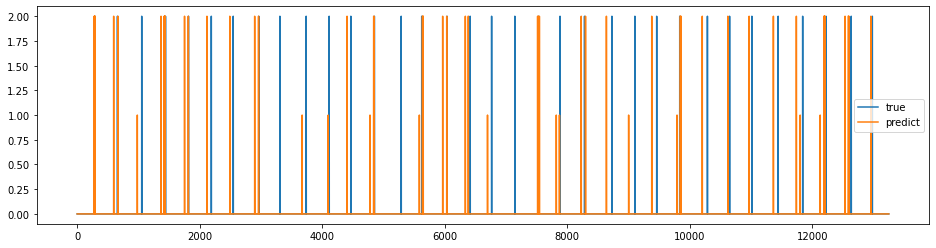

In [94]:
wheeze_per_resp_acc(predict, t1_y)

plt.figure(figsize=(16,4))
plt.plot(t1_y, label = 'true')
plt.plot(predict, label = 'predict')
# plt.xlim(1500, 2000)

plt.legend()

In [95]:
y_pred = model.predict(t2_x)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t2_y, predict)
f1 = f1_score(t2_y, predict, average='weighted')
roc_auc = roc_auc_score(t2_y, predict)
cm = confusion_matrix(t2_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

acc: 0.991980206467025
f1: 0.9925750207076683
roc_auc: 0.49768855406215223
[[11627     5    49]
 [    0     0     0]
 [   40     0     0]]


prediction
21 / 22
test
39 / 39


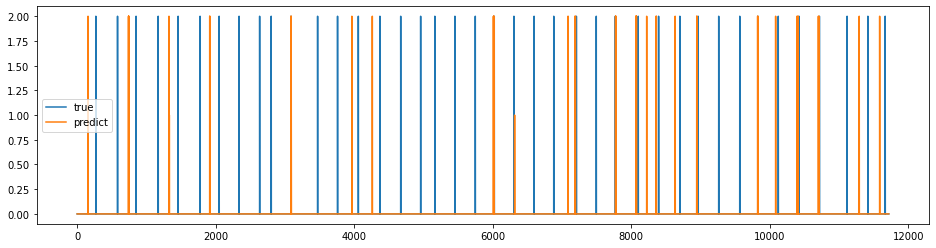

In [96]:
wheeze_per_resp_acc(predict, t2_y)

plt.figure(figsize=(16,4))
plt.plot(t2_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

# plt.xlim(0,1000)

In [97]:
y_pred = model.predict(t3_x)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t3_y, predict)
f1 = f1_score(t3_y, predict, average='weighted')
roc_auc = roc_auc_score(t3_y, predict)
cm = confusion_matrix(t3_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

acc: 0.9695005401811685
f1: 0.9812116850051822
roc_auc: 0.5228922940496916
[[11663     8   321]
 [    0     0     0]
 [   38     0     3]]


prediction
38 / 38
test
40 / 40


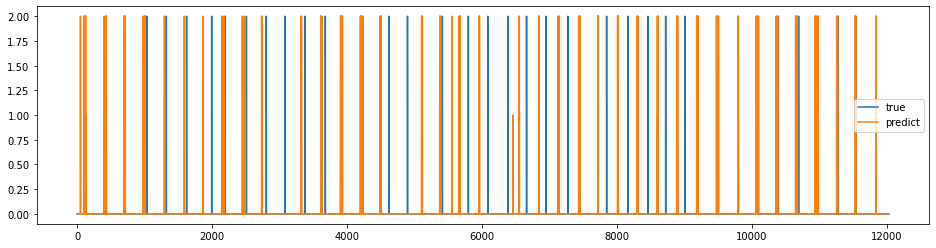

In [98]:
wheeze_per_resp_acc(predict, t3_y)

plt.figure(figsize=(16,4))
plt.plot(t3_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

In [99]:
y_pred = model.predict(t4_x)

predict=[]
for i in  y_pred:
    predict.append(np.argmax(i))

predict = np.array(predict)

acc = accuracy_score(t4_y, predict)
f1 = f1_score(t4_y, predict, average='weighted')
roc_auc = roc_auc_score(t4_y, predict)
cm = confusion_matrix(t4_y, predict)

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

acc: 0.9685052491251458
f1: 0.9797373848341228
roc_auc: 0.48635983263598326
[[5812   15  148]
 [   0    0    0]
 [  26    0    0]]


prediction
19 / 19
test
19 / 19


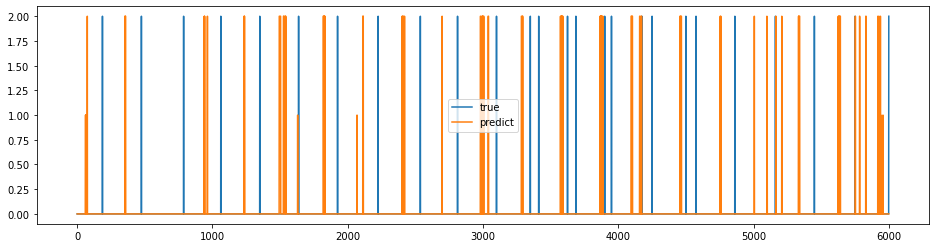

In [100]:
wheeze_per_resp_acc(predict, t4_y)

plt.figure(figsize=(16,4))
plt.plot(t4_y, label = 'true')
plt.plot(predict, label = 'predict')

plt.legend()

In [44]:
n_mels = 128
frame_sec = 0.025
step_sec = 0.01
label_ratio = 1

X_test, y_test = make_validation_dataset_keras(val_file_path, val_ordered_file_list, n_mels, frame_sec, step_sec, label_ratio)

In [45]:
y_pred = model.predict(X_test)

In [46]:
acc =accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1))
f1=f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average='weighted')

roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')

print('acc:', acc)
print('f1:', f1)
print('roc_auc:', roc_auc)
print(cm)

acc: 0.8675776397515528
f1: 0.8716075069265067
roc_auc: 0.9708689022613854
[[0.86376576 0.00447336 0.13176088]
 [0.07082631 0.8381113  0.09106239]
 [0.05858171 0.04624872 0.89516958]]


In [41]:
y_pred_0 = y_pred[:,0]
y_pred_1 = y_pred[:,1]
y_pred_2 = y_pred[:,2]

y_test_0 = y_test[:,0]
y_test_1 = y_test[:,1]
y_test_2 = y_test[:,2]

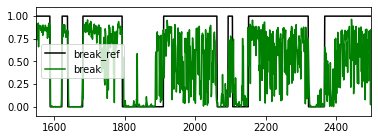

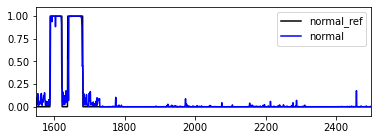

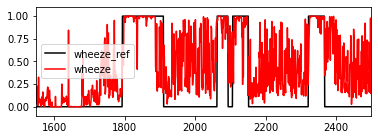

In [49]:
view_start = 1550
view_end = 2500

# x = np.arange(len(y_test_0))

plt.figure(figsize=(6,2))
plt.plot(y_test_0, label='break_ref', color='black')
plt.plot(y_pred_0, label='break', color='g')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_break.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_1, label='normal_ref', color='black')
plt.plot(y_pred_1, label='normal', color='b')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_normal.svg')

plt.figure(figsize=(6,2))
plt.plot(y_test_2, label='wheeze_ref', color='black')
plt.plot(y_pred_2, label='wheeze', color='r')
plt.ylim(-0.1,1.1)
plt.xlim(view_start,view_end)
plt.legend()
# plt.savefig('svg_images/figure6-2_wheeze.svg')